## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import plotly
import plotly.express as px

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [29]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [31]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
display(data[data['group']=='A']['date'].describe())
display(data[data['group']=='B']['date'].describe())
# или более короткая запись display(data.groupby('group')['date'].agg(['min', 'max']))

C:\Users\Павел\AppData\Local\Temp\ipykernel_15804\688378883.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data[data['group']=='A']['date'].describe())


count                  147202
unique                     23
top       2021-01-21 00:00:00
freq                     6823
first     2021-01-02 00:00:00
last      2021-01-24 00:00:00
Name: date, dtype: object

C:\Users\Павел\AppData\Local\Temp\ipykernel_15804\688378883.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data[data['group']=='B']['date'].describe())


count                  147276
unique                     23
top       2021-01-06 00:00:00
freq                     6844
first     2021-01-02 00:00:00
last      2021-01-24 00:00:00
Name: date, dtype: object

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [32]:
print('Количество посещений сайта в группах А и В равно:')
display(data.groupby('group')['user_id'].count())

print('Суммарное количество покупок в группах равно:')
display(data.groupby('group')['purchase'].sum())

print('Сумма всех покупок в каждой группе ровна:')
display(data.groupby('group')['price'].sum() /1e6)

Количество посещений сайта в группах А и В равно:


group
A    147202
B    147276
Name: user_id, dtype: int64

Суммарное количество покупок в группах равно:


group
A    17723
B    17514
Name: purchase, dtype: int64

Сумма всех покупок в каждой группе ровна:


group
A    1436.26
B    1554.10
Name: price, dtype: float64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [33]:
users_a = data[data['group'] == 'A']
users_b = data[data['group'] == 'B']
intersactions = set(users_a['user_id']).intersection(set(users_b['user_id']))
print(len(intersactions))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [34]:
updated_data = data[data['user_id'].apply(lambda x: x not in intersactions)]
updated_data.shape[0]

290688

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

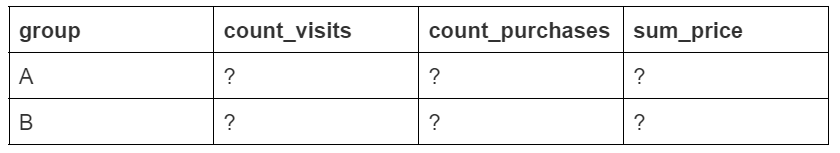
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [40]:
grouped_data = updated_data.groupby('group').agg({
    'user_id' : 'count',
    'purchase' : 'sum',
    'price' : 'sum'}
).rename(columns={
    'user_id' : 'count_visits',
    'purchase' : 'count_purchases',
    'price' : 'sum_price'
})
display(grouped_data)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?



*Исходя из полученной таблицы можно сделать выводы о том что выборки групп **А** и **Б** не равны, так как данные о количестве посещений отличаются на **74***

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [41]:
grouped_data['conversion'] = (grouped_data['count_purchases'] / grouped_data['count_visits']) *100
grouped_data['mean_check'] = (grouped_data['sum_price'] / grouped_data['count_purchases'])
display(grouped_data)

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

В настоящий момент несмотря на то что количсество посещений на сайт А меньше, по конверсии он привосходит сайт В, но всего лишь на 0.14 что не является значительной разницей.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [50]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group',
    columns='price',
    values='purchase',
    aggfunc='sum'
)
display(pivot)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

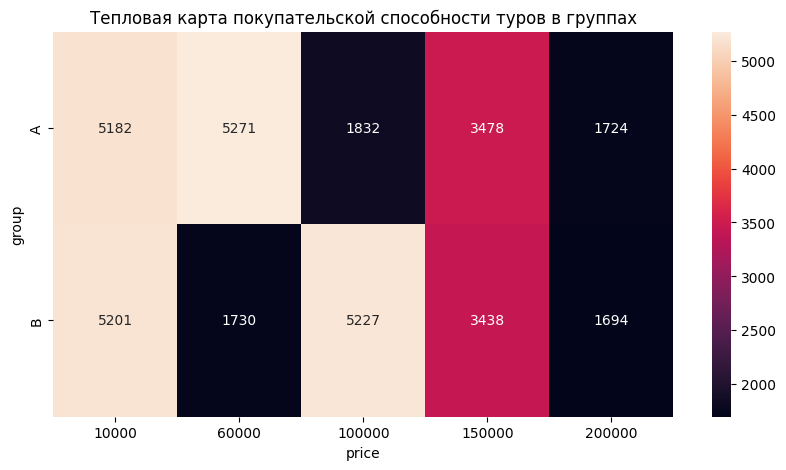

In [49]:
fig = plt.figure(figsize= (10,5))
ax = sns.heatmap(pivot, fmt='.0f', annot=True)
ax.set_title('Тепловая карта покупательской способности туров в группах');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

ваши выводы здесь

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [57]:
dayli_data = updated_data.groupby(['date', 'group']).agg({
    'user_id' : 'count',
    'purchase' : 'sum',
    'price' : 'sum'}
).reset_index().rename(columns={
    'user_id' : 'count_visits',
    'purchase' : 'count_purchases',
    'price' : 'sum_price'
})
dayli_data['conversion'] = dayli_data['count_purchases'] / dayli_data['count_visits'] * 100
dayli_data['mean_check'] = dayli_data['sum_price'] / dayli_data['count_purchases']
display(dayli_data[dayli_data['date'] == '2021-01-03'][['group', 'conversion']])
display(dayli_data[dayli_data['date'] == '2021-01-03'][['group', 'mean_check']].round())

,group,conversion
2,A,11.340206
3,B,11.391449


,group,mean_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [63]:
dayli_data['cum_count_visits'] = dayli_data.groupby('group')['count_visits'].cumsum()
dayli_data['cum_count_purchases'] = dayli_data.groupby('group')['count_purchases'].cumsum()
dayli_data['cum_sum_price'] = dayli_data.groupby('group')['sum_price'].cumsum()
dayli_data['cum_conversion'] = dayli_data['cum_cocount_purchases'] / dayli_data['cum_count_visits'] * 100
dayli_data['cum_mean_check'] = dayli_data['cum_sum_price'] / dayli_data['cum_count_purchases']
dayli_data.head()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_cocount_purchases,cum_sum_price,cum_conversion,cum_count_purchases,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,359,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,345,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,1107,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,1099,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,1906,81668.415530


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [66]:
fig = px.line(
    data_frame=dayli_data,
    x='date',
    y='cum_conversion',
    color='group',
    title= 'График кумулятивной конверсии по дням'
)
fig.show()
fig_2 = px.line(
    data_frame=dayli_data,
    x='date',
    y='cum_mean_check',
    color='group',
    title= 'График кумулятивного среднего чека по дням'
)
fig_2.show()

Исходя из построенных графиков можно сделать вывод о том, что после *14* января кумулятивный средний чек и кумулятивная конверсия стабилизировались, следовательно можно сделать вывод о том что А/В тест *завершен*. Кумулятивный средний чек в **группе В** гораздо выше на протяжении всего теста, но кумулятивная конверсия **группы В** ниже на протяжении всего отрезка. Следовательно людей зашедших на сайт и совершивших покупку чуть меньше но если они производили покупку то на туры с более высокой ценой.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
# ваш код здесь

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 